In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [16]:
#Crank-Nicolson solution zero diffusion across downstream boundary 
#with Crank-Nicolson reaction term that couples concentrations.
#Concentrations are solved by creating a single column matrix 
#that contains both C1 and C2.
from scipy.sparse import dia_matrix
from scipy.sparse.linalg import spsolve
#define parameters
ntimes = 1000
endtime = 2.0
dt = endtime/(ntimes-1)
nx = 1000
L=3000.
D_w = 30.
D_a = 30.
V_a = 1.
V_w = 0.1
T = V_w/V_a
Pe_a = L*V_a/D_a
Pe_w = L*V_w/D_w
xmax = 1.
Lambda_w = 0.5
Lambda_a = Lambda_w*T

#k=0.2
dx = xmax/(nx-1.)
#Construct A matrix. Start by creating diagonals of upper left block, which are similar to before 
A_upper_air = dt*(1./(4.*dx) - 1./(2.*Pe_a*dx**2.))*ones(nx-1) 
A_lower_air = dt*(-1./(4.*dx) - 1./(2.*Pe_a*dx**2.))*ones(nx-1)
A_mid_air = (T+dt/(Pe_a*dx**2.))*ones(nx-1) + dt*Lambda_a/2.#The middle diagonal gets an added reaction term now
A_upper_water = dt*(1./(4.*dx) - 1./(2.*Pe_w*dx**2.))*ones(nx-1) 
A_lower_water = dt*(-1./(4.*dx) - 1./(2.*Pe_w*dx**2.))*ones(nx-1)
A_mid_water = (1.+dt/(Pe_w*dx**2.))*ones(nx-1) + dt*Lambda_w/2.#The middle diagonal gets an added reaction term now

#Knock out elemnts of upper and lower rows for sparse storage
A_upper_air[0] = 0.
A_lower_air[-1] = 0.
A_upper_water[0] = 0.
A_lower_water[-1] = 0.

#Modify lower row for boundary condition
A_lower_air[-2] = -dt/(2.*dx)
A_mid_air[-1] = T + dt/(2*dx) + dt*Lambda_a/2.#Again, there is an additional term in the bnd. cond. related to reaction
A_lower_water[-2] = -dt/(2.*dx)
A_mid_water[-1] = 1. + dt/(2*dx) + dt*Lambda_w/2.#Again, there is an additional term in the bnd. cond. related to reaction

#Now create full diagonals by appending upper left block diagonals to themselves
A_upper = append(A_upper_air,A_upper_water)
A_lower = append(A_lower_air,A_lower_water)
A_mid = append(A_mid_air,A_mid_water)
#Create upper left and lower right blocks, which only have diagonal non-zero elements
A_up_block_diag = zeros(2*(nx-1))#Diagonal in sparse form is mostly zeros
A_up_block_diag[nx:] = -dt*Lambda_a/2.#Set non-zero elements in 2nd half of array
A_low_block_diag = zeros(2*(nx-1))
A_low_block_diag[:nx] = -dt*Lambda_w/2.#Set non-zero elements in 1st half of array
#Create stacked rows version of A
A_tmp = vstack((A_up_block_diag,A_upper, A_mid, A_lower,A_low_block_diag))
#Construct sparse array
offsets = [nx,1,0,-1,-nx]#These indicate the numbers of the non-zero diagonals corresponding to the rows in A_tmp
#Create sparse matrix using dia_matrix:
#  You have to provide the non-zero diagonals and their offsets in a tuple as the first argument.
#  You can also specify the total size of the matrix with the shape keyword
A = dia_matrix((A_tmp,offsets), shape=(2*(nx-1),2*(nx-1)))
A.tocsr()
#Create concentrations array for both species
C = zeros([ntimes,2*nx])
#Set initial condition
C[0,:]=0.
#set upstream concentrations
C_a_upstream = 0.
C_w_upstream = 0.5
C[:nx,0] = C_a_upstream
C[nx:,0] = C_w_upstream
#Create both halves of b matrix, they are treated separately below for clarity
bC_a = zeros(nx-1)
bC_w = zeros(nx-1)
for n in arange(ntimes-1):
    #Set C1 and C2 to concentrations of two species at nth timestep
    C_a = C[n,:nx]
    C_w = C[n,nx:]
    #Calculate the components of b for the top half
    bC_a[0:-1] = C_a[1:-1]*(T-dt/(Pe_a*dx**2.)) + C_a[0:-2]*(dt/(4.*dx) + dt/(2.*Pe_a*dx**2.)) \
                        + C_a[2:]*(-dt/(4.*dx) + dt/(2.*Pe_a*dx**2.))\
                        - dt*Lambda_a*(C_a[1:-1] - C_w[1:-1])/2. #This row contains reaction term
    bC_a[0] += dt*(1./(4.*dx) + 1./(2.*Pe_a*dx**2.))*C_a_upstream
    bC_a[-1] = (T-dt/(2.*dx))*C_a[-1] + (dt/(2*dx))*C_a[-2] - dt*Lambda_a*(C_a[-1] - C_w[-1])/2.#Boundary gets additional reaction term
    bC_w[0:-1] = C_w[1:-1]*(1.-dt/(Pe_w*dx**2.)) + C_w[0:-2]*(dt/(4.*dx) + dt/(2.*Pe_w*dx**2.))\
                        + C_w[2:]*(-dt/(4.*dx) + dt/(2.*Pe_w*dx**2.))\
                        + dt*Lambda_w*(C_a[1:-1] - C_w[1:-1])/2. #This row contains reaction term
    bC_w[0] += dt*(1./(4.*dx) + 1./(2.*Pe_w*dx**2.))*C_w_upstream
    bC_w[-1] = (1.-dt/(2.*dx))*C_w[-1] + (dt/(2*dx))*C_w[-2] + dt*Lambda_w*(C_a[-1] - C_w[-1]) /2.#Boundary gets additional reaction term
    #Put together upper and lower halves of b
    b = append(bC_a,bC_w)
    #Use sparse linear solver
    Ctmp = spsolve(A, b)
    #Assign values from solver into C array avoiding upstream boundary locations (first row of each half of C)
    C[n+1,1:nx] = Ctmp[:nx-1]
    C[n+1,nx+1:] = Ctmp[nx-1:]
    

Text(0, 0.5, 'Concentration')

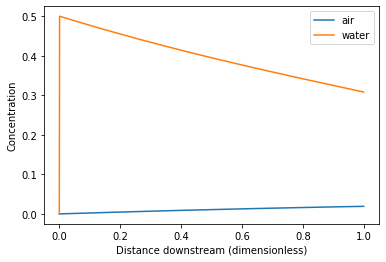

In [15]:
x = linspace(0,1,nx)
plot(x,C[950,:nx])
plot(x,C[950,nx:])
legend(['air','water'])
#Can compare against previous solution for D
#plot(x,D[200,:],'--')

xlabel('Distance downstream (dimensionless)')
ylabel('Concentration')

In [66]:
#Crank-Nicolson solution zero diffusion across downstream boundary 
#with explicit reaction term that couples concentrations
from scipy.linalg import solve_banded
#define parameters for run
ntimes = 1000
endtime = 2.0
dt = endtime/(ntimes-1)
nx = 1000
L=3000.
D_w = 30.
D_a = 30.
V_a = -1
V_w = 0.1

T = V_w/np.abs(V_a)
Pe_a = L*np.abs(V_a)/D_a
Pe_w = L*V_w/D_w
xmax = 1.
Lambda_w = 15
Lambda_a = Lambda_w*T
xmax = 1.
dx = xmax/(nx-1.)
#Construct A matrix
A_upper_air = dt*(np.sign(V_a)*1./(4.*dx) - 1./(2.*Pe_a*dx**2.))*ones(nx-1) 
A_lower_air = dt*(-np.sign(V_a)*1./(4.*dx) - 1./(2.*Pe_a*dx**2.))*ones(nx-1)
A_mid_air = (T+dt/(Pe_a*dx**2.))*ones(nx-1) 
A_upper_water = dt*(1./(4.*dx) - 1./(2.*Pe_w*dx**2.))*ones(nx-1) 
A_lower_water = dt*(-1./(4.*dx) - 1./(2.*Pe_w*dx**2.))*ones(nx-1)
A_mid_water = (1.+dt/(Pe_w*dx**2.))*ones(nx-1)

#A_upper = dt*(1./(4.*dx) - 1./(2.*Pe*dx**2.))*ones(nx-1)
#A_lower = dt*(-1./(4.*dx) - 1./(2.*Pe*dx**2.))*ones(nx-1)
#A_mid = (1.+dt/(Pe*dx**2.))*ones(nx-1)
A_upper_air[0] = 0.
A_lower_air[-1] = 0.
if V_a>0:
    A_lower_air[-2] = -dt/(2.*dx)
    A_mid_air[-1] = T + dt/(2*dx)
else:
    A_upper_air[1] = -dt/(2.*dx)
    A_mid_air[0] = T + dt/(2*dx)
    
A_upper_water[0] = 0.
A_lower_water[-1] = 0.
A_lower_water[-2] = -dt/(2.*dx)
A_mid_water[-1] = 1. + dt/(2*dx)

A_air = vstack((A_upper_air, A_mid_air, A_lower_air))
A_water = vstack((A_upper_water, A_mid_water, A_lower_water))

#Create two concentration arrays for two species
C_a = zeros([ntimes,nx])
C_w = zeros([ntimes,nx])
#Set initial conditions for both species
C_a[0,:]=0.
C_w[0,:]=0.
#Set upstream boundary concentrations
C_a_upstream = 0.
C_w_upstream = 1.
if V_a>0:
    C_a[:,0] = C_a_upstream
else:
    C_a[:,-1] = C_a_upstream

C_w[:,0] = C_w_upstream
#Create b arrays for each concentration variable
bC_a = zeros(nx-1)
bC_w = zeros(nx-1)
for n in arange(ntimes-1):
    #Calculate b matrix for C
    if V_a>0:
        bC_a[0:-1] = C_a[n,1:-1]*(T-dt/(Pe_a*dx**2.)) + C_a[n,0:-2]*(np.sign(V_a)*dt/(4.*dx) + dt/(2.*Pe_a*dx**2.)) \
                        + C_a[n,2:]*(-np.sign(V_a)*dt/(4.*dx) + dt/(2.*Pe_a*dx**2.))\
                        - dt*Lambda_a*(C_a[n,1:-1] - C_w[n,1:-1]) #Last line here is added to previous C-N solution to include reaction
        bC_a[0] += dt*(1./(4.*dx) + 1./(2.*Pe_a*dx**2.))*C_a_upstream
        bC_a[-1] = (T-dt/(2.*dx))*C_a[n,-1] + (dt/(2*dx))*C_a[n,-2] - dt*Lambda_a*(C_a[n,-1] - C_w[n,-1])#last term gets added to boundary cond.
    else:
        bC_a[1:] = C_a[n,1:-1]*(T-dt/(Pe_a*dx**2.)) + C_a[n,0:-2]*(np.sign(V_a)*dt/(4.*dx) + dt/(2.*Pe_a*dx**2.)) \
                        + C_a[n,2:]*(-np.sign(V_a)*dt/(4.*dx) + dt/(2.*Pe_a*dx**2.))\
                        - dt*Lambda_a*(C_a[n,1:-1] - C_w[n,1:-1]) #Last line here is added to previous C-N solution to include reaction
        bC_a[-1] += dt*(1./(4.*dx) + 1./(2.*Pe_a*dx**2.))*C_a_upstream
        bC_a[0] = (T-dt/(2.*dx))*C_a[n,0] + (dt/(2*dx))*C_a[n,1] - dt*Lambda_a*(C_a[n,0] - C_w[n,0])#last term gets added to boundary cond.
    #Calculate b matrix for C_w
    bC_w[0:-1] = C_w[n,1:-1]*(1.-dt/(Pe_w*dx**2.)) + C_w[n,0:-2]*(dt/(4.*dx) + dt/(2.*Pe_w*dx**2.))\
                        + C_w[n,2:]*(-dt/(4.*dx) + dt/(2.*Pe_w*dx**2.))\
                        + dt*Lambda_w*(C_a[n,1:-1] - C_w[n,1:-1])#Last line here is added to previous C-N solution to include reaction
    bC_w[0] += dt*(1./(4.*dx) + 1./(2.*Pe_w*dx**2.))*C_w_upstream
    bC_w[-1] = (1.-dt/(2.*dx))*C_w[n,-1] + (dt/(2*dx))*C_w[n,-2] + dt*Lambda_w*(C_a[n,-1] - C_w[n,-1])#last term gets added to boundary cond.  
    if V_a>0:
        C_a[n+1,1:] = solve_banded((1,1), A_air, bC_a)
    else:
        C_a[n+1,:-1] = solve_banded((1,1), A_air, bC_a)
   
    C_w[n+1,1:] = solve_banded((1,1), A_water, bC_w)
    

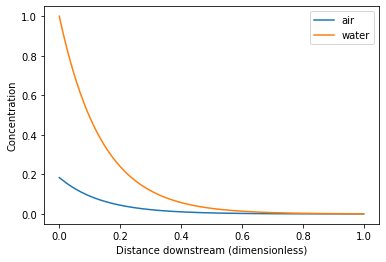

In [68]:
x = linspace(0,1,nx)
plot(x,C_a[960,:])
plot(x,C_w[960,:])
#plot(x,C_a[160,:])
#plot(x,C_w[160,:])
#plot(x,C_a[260,:])
#plot(x,C_w[260,:])
#plot(x,C_a[360,:])
#plot(x,C_w[360,:])

legend(['air','water'])
#Can compare against previous solution for D
#plot(x,D[200,:],'--')

xlabel('Distance downstream (dimensionless)')
ylabel('Concentration');

1